# imports

In [21]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
# print("In module products sys.path[0], __package__ ==", sys.path[0], __package__)

# import os
import os.path
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from typing import Callable
import re
from math import floor
import statistics

from test_runner import *
from test_runner.translators import *
from test_runner.analysers import SearchResult


# from test_runner import TestCase, BaseTestRunner, LiftedPlanningRunner, GroundedPlanningRunner
# from test_runner.tapaal_caller import QueryResult

from parse_results import translator_result_type, search_result_type#, load_translator_results, load_search_results, 


# Style Config

In [22]:
# downward = circle red
# grounded = square green
# lifted = triangle blue

# Load Data

In [23]:
from result_collection import result_collection, result_container


infinite = float("inf")
results_dir = "../results"
plot_save_dir = "../results/plots"
os.makedirs(plot_save_dir, exist_ok=True)
results_path = "../results"

domain_sub_range = range(1, 32)


results = result_container()


def load_translator_results() -> translator_result_type:
    with open(os.path.join(results_path, f"translator_results.pickle"), "rb") as f:
        return pickle.load(f)


def load_search_results() -> search_result_type:
    with open(os.path.join(results_path, f"search_results.pickle"), "rb") as f:
        return pickle.load(f)



_loaded_translator_results: translator_result_type = load_translator_results()
_loaded_search_results: search_result_type = load_search_results()


# Translator -> domain -> result[]
translator_results_str_lookup: dict[str, dict[str, "BaseTranslator"]] = dict()


# Translator Results
for translator, domains in _loaded_translator_results.items():
    translator_results_str_lookup[translator.name] = dict()
    for domain, test_results in domains.items():
        translator_results_str_lookup[translator.name][domain.name] = test_results


# Search Results
domain_regex = re.compile(r"^(?P<domain>.+?)_(?P<id>\d\d)$", re.MULTILINE)
for translator, translator_results in _loaded_search_results.items():
    for test_case, test_results in translator_results.items():
        for searcher, search_results in test_results.items():

            domain_name = domain_regex.match(test_case.name)["domain"]
            domain_sub_id = int(domain_regex.match(test_case.name)["id"])

            specific_translator_results = translator_results_str_lookup[translator.name][test_case.name]
            specific_searcher_results = search_results


            if (
                translator.name in results.translators and
                domain_name     in results.translators[translator.name].domains and
                searcher.name   in results.translators[translator.name].domains[domain_name].searchers
            ):
                results.translators[translator.name].domains[domain_name].searchers[searcher.name].set(domain_sub_id, specific_translator_results, specific_searcher_results)
            
            else:

                _result_collection = result_collection(domain_sub_range)
                _result_collection.set(domain_sub_id, specific_translator_results, specific_searcher_results)

                # results.set(translator.name, domain.name, searcher.name, _result_collection)
                results.set(translator.name, domain_name, searcher.name, _result_collection)




In [24]:
for translator_name, translator_results in results.translators.items():
    for domain_name, test_results in translator_results.domains.items():
        for searcher_name, result_collection in test_results.searchers.items():

            if searcher_name == "no_color_optimizations":
                result_collection.style = None
                continue

            if translator_name == "colored" and searcher_name == "rpfs":
                result_collection.display_name = "color_rpfs"
                result_collection.style = "s-"
                result_collection.color="#332288"
                continue
            
            if translator_name == "colored" and searcher_name == "rpfs_safe_reductions":
                result_collection.display_name = "colored"
                result_collection.style = "s-"
                result_collection.color="#117733"
                continue         
               
            if translator_name == "colored" and searcher_name == "rpfs_safe_reductions_unlimited_intervals":
                result_collection.display_name = "colored_NT"
                result_collection.style = "s-"
                result_collection.color="#44AA99"
                continue

            if translator_name == "colored_hierarchy" and searcher_name == "rpfs":
                result_collection.display_name = "hier_rpfs"
                result_collection.style = "s-"
                result_collection.color="#88CCEE"
                continue

            if translator_name == "colored_hierarchy" and searcher_name == "rpfs_safe_reductions":
                result_collection.display_name = "hier_v1"
                result_collection.style = "s-"
                result_collection.color="#DDCC77"
                continue

            if translator_name == "colored_hierarchy" and searcher_name == "rpfs_safe_reductions_unlimited_intervals":
                result_collection.display_name = "hier_v1_NT"
                result_collection.style = "s-"
                result_collection.color="#CC6677"
                continue

            if translator_name == "colored_hierarchyv2" and searcher_name == "rpfs_safe_reductions":
                result_collection.display_name = "hier_v2"
                result_collection.style = "s-"
                result_collection.color="#ADD8E6"
                continue

            if translator_name == "colored_hierarchyv2" and searcher_name == "rpfs_safe_reductions_unlimited_intervals":
                result_collection.display_name = "hier_v2_NT"
                result_collection.style = "s-"
                result_collection.color="#00008B"
                continue

            if translator_name == "grounded" and searcher_name == "rpfs":
                result_collection.display_name = "grounded"
                result_collection.style = "v-"
                result_collection.color="#AA4499"
                continue

            if translator_name == "downward" and searcher_name == "lama_first":
                result_collection.display_name = "downward"
                result_collection.style = "o-"
                result_collection.color="#882255"
                continue

            print("Unstyled config")




# Plots

## Count Reductions

In [25]:
# import pandas as pd

reductions = dict()
domains_per_reduction = dict()


for translator_name, translator_results in results.translators.items():
    # if translator_name == "colored": continue
    # if translator_name == "colored_hierarchy": continue
    if translator_name == "grounded": continue
    if translator_name == "downward": continue

    for searcher_name, searcher_results in translator_results.searchers.items():
        for domain_name, result_collections in searcher_results.domains.items():

            for domain_sub_id, search_results in enumerate(result_collections.search_results):
                
                if len(result_collection.search_results) == 0:
                    continue

                search_result = result_collection.search_results[0]
                if hasattr(search_result, "reductions_applied"):
                    for (rule_id, count) in search_result.reductions_applied.items():
                        if not rule_id in reductions:
                            reductions[rule_id] = 0
                            domains_per_reduction[rule_id] = list()
                        
                        reductions[rule_id] += count
                        if count > 0:
                            domains_per_reduction[rule_id].append(f"{translator.name}:{domain_name.name}_{domain_sub_id}")
    
    #print(test_case.name)
for (reduction_id, count) in reductions.items():
    print(str.ljust(f"{reduction_id}: {count}", 30) + f"{domains_per_reduction[rule_id]}")


    

# -r 3 2,3,4,6,8,11,12

# Overview Plot
plot = run config

x = IPC instance id

y = median time

In [26]:
from test_runner.analysers import TranslatorResult, SearchResult
from result_collection import result_collection

# Generic


def median_reduction(translator_reduction: Callable[[TranslatorResult], float], searcher_reduction: Callable[[SearchResult], float]) -> Callable[[result_collection], list[float]]:
    def reduction(rc: result_collection) -> list[float]:
        translator_vals_per_task = [[translator_reduction(x) for x in translator_results] for translator_results in rc.translator_results]
        search_vals_per_task     = [[searcher_reduction(x) for x in search_results] for search_results in rc.search_results]


        translator_numeric = [statistics.median(results) if len(results) > 0 else infinite for results in translator_vals_per_task]
        searcher_numeric   = [statistics.median(results) if len(results) > 0 else infinite for results in search_vals_per_task]


        added = [ x + y for x, y in zip(translator_numeric, searcher_numeric)]

        return added
    
    return reduction


def minimum_reduction(translator_reduction: Callable[[TranslatorResult], float], searcher_reduction: Callable[[SearchResult], float]) -> Callable[[result_collection], list[float]]:
    def reduction(rc: result_collection) -> list[float]:
        translator_vals_per_task = [[translator_reduction(x) for x in translator_results] for translator_results in rc.translator_results]
        search_vals_per_task     = [[searcher_reduction(x) for x in search_results] for search_results in rc.search_results]


        translator_numeric = [statistics.median(results) if len(results) > 0 else infinite for results in translator_vals_per_task]
        searcher_numeric   = [statistics.median(results) if len(results) > 0 else infinite for results in search_vals_per_task]


        added = [ x + y for x, y in zip(translator_numeric, searcher_numeric)]

        return added
    
    return reduction


def median_search_property(prop_name: str) -> Callable[[result_collection], list[float]]:
    return median_reduction(
        lambda res: 0,
        lambda res: res.get(prop_name, infinite)
    )


# Time

median_time_total = median_reduction(
    lambda res: res.time.seconds_system + res.time.seconds_user,
    lambda res: res.time.seconds_system + res.time.seconds_user if res.has_plan else infinite
)


minimum_time_search = minimum_reduction(
    lambda res: 0,
    lambda res: res.time.seconds_system + res.time.seconds_user if res.has_plan else infinite
)

median_time_translate = minimum_reduction(
    lambda res: res.time.seconds_system + res.time.seconds_user if res.valid_translation else infinite,
    lambda res: 0
)

median_time_search = median_reduction(
    lambda res: 0,
    lambda res: res.time.seconds_system + res.time.seconds_user if res.has_plan else infinite
)


minimum_time_total = minimum_reduction(
    lambda res: res.time.seconds_system + res.time.seconds_user,
    lambda res: res.time.seconds_system + res.time.seconds_user if res.has_plan else infinite
)





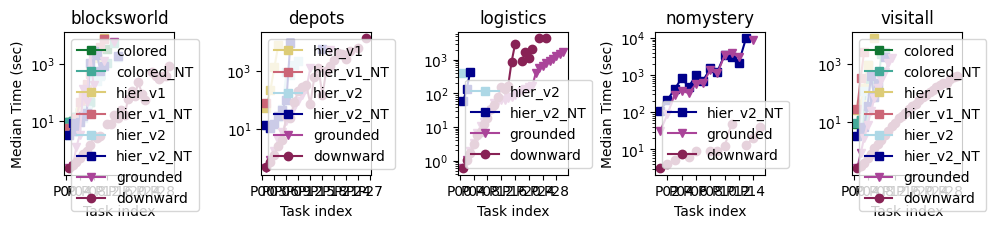

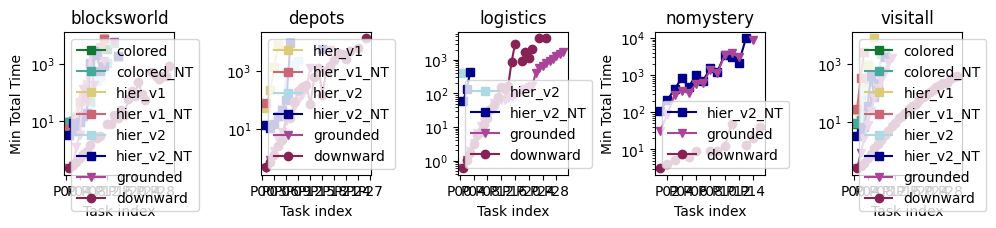

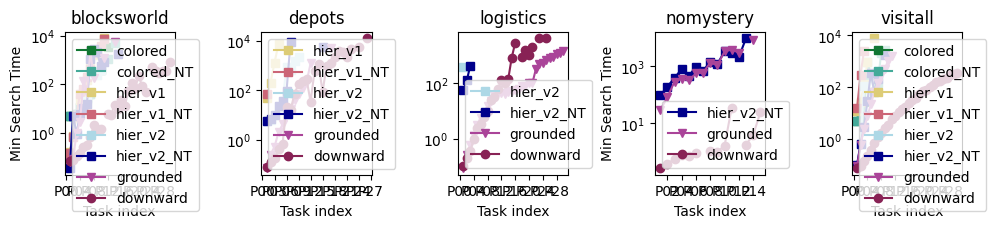

In [27]:
# System + User Time

import matplotlib


# class XTickFormater(matplotlib.ticker.Formatter):
#     def format_ticks(values):
#         return [f"P{v+1}" for v in values]
# xtickFormatter = XTickFormater()
# Formerly 1+ to x axis
xtickFormatter = matplotlib.ticker.FuncFormatter(lambda x, pos: f"P{x:02.0f}")
xtickLocator = matplotlib.ticker.MaxNLocator(integer=True)


def make_overview_cactus_plot(name: str, description: str, reduction: Callable[["result_collection"], list[float]]):
    fig_rows = 5
    fig_cols = 5


    # Domain -> searcher -> translator -> IPCMedian[] 
    # search_results_domain_searcher_translator_test_case


    i=1
    # scale = 4.5
    scale = 10
    # fig = plt.figure(figsize=(2.3*scale, scale))
    fig = plt.figure(figsize=(scale, scale))
#    ax = fig.gca()
    # plt.title(description)

    for domain_name, domain_results in results.domains.items():


        subplt = plt.subplot(fig_rows, fig_cols, i)
        max_y = 0
        axis = plt.gca()

        for translator_name, translator_results in domain_results.translators.items():
            for searcher_name, _result_collection in translator_results.searchers.items():

                #plt.plot(list(median_times.values())[0], 'o-', label=f"{translator.name}({searcher.name})")
                # plt.plot(median_times, 'o-', label=f"{translator.name}({searcher.name})")
                reduced_data = reduction(_result_collection)
                if _result_collection.style != None and len([x for x in reduced_data if x != infinite]) > 0:
                    
                    plt.plot(reduced_data, _result_collection.style, color=_result_collection.color, label=_result_collection.display_name)#f"{translator.name}({searcher.name})")

                    #plt.xticks(range(0,30), [f"P{x+1}" for x in range(0,30)])
                    # plt.xlabels([f"P{x+1}" for x in range(0,30)])
                    #(xlim_min, xlim_max) = axis.get_xlim()
                    #axis.set_xlim([xlim_min, min(xlim_max, 30)])

                    # yaxis begins at 0
                    #(ylim_min, ylim_max) = axis.get_ylim()
                    max_y = max(max_y, max([x for x in reduced_data if x != infinite]))


                    subplt.xaxis.set_major_formatter(xtickFormatter)
                    subplt.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
                    # subplt.axes.ticklabel_format(xtickFormatter, "x")
                    # fig.gca().axes.xaxis.format_ticks(xtickFormatter)
                #yticks = range(0,30)
                #plt.yticks(yticks, step=1)
#                ax.xaxis.set_major_locator(MaxNLocator(integer=True)) # Integer x axis

        # axis.set_ylim(bottom=0)

        plt.title(domain_name)
        #plt.title(f'{description} - {test_case.name}')
        plt.gca().legend(loc='best')
        plt.xlabel('Task index')
        if (i-1)%3 == 0:
            plt.ylabel(description)
        subplt.set_yscale("log")
        i += 1


    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    plt.tight_layout()
    plt.savefig(os.path.join(plot_save_dir, f"{name}.png"))



make_overview_cactus_plot("overview_med_time_total", 'Median Time (sec)', median_time_total)
make_overview_cactus_plot("overview_min_time_total", "Min Total Time", minimum_time_total)
make_overview_cactus_plot("overview_min_time_search", "Min Search Time", minimum_time_search)



# #make_overview_cactus_plot("overview_min_time", "Min Total Time", lambda res: res.min_time)
# #make_overview_cactus_plot("overview_min_verificaiton_time", 'Min verification time', lambda resultCollection: min([res.get("time_verification", infinite) for res in resultCollection.raw])) 

# make_overview_cactus_plot("overview_time", 'Median Time (sec)', lambda res: res.median_time)
# #make_overview_cactus_plot("overview_time_minus_unfolding", 'Median Time (sec) - minus unfolding', lambda res: res.median_time_minus_unfolding)
# #make_overview_cactus_plot("overview_time_minus_unfolding", 'Median unfolding Time (sec)', lambda res: res.median_unfolding_time)
# make_overview_cactus_plot("overview_verification_time", "Median Verification Time", lambda res: res.median_verification_time)
# # make_overview_cactus_plot("overview_unfolded_places", "Unfolded Place Count", lambda resultCollection: resultCollection.raw[0].get("place_count_after_reduction", infinite))
# # make_overview_cactus_plot("overview_unfolded_transitions", "Unfolded Transition Count", lambda resultCollection: resultCollection.raw[0].get("transition_count_after_reduction", infinite))


# Single Domain Overview

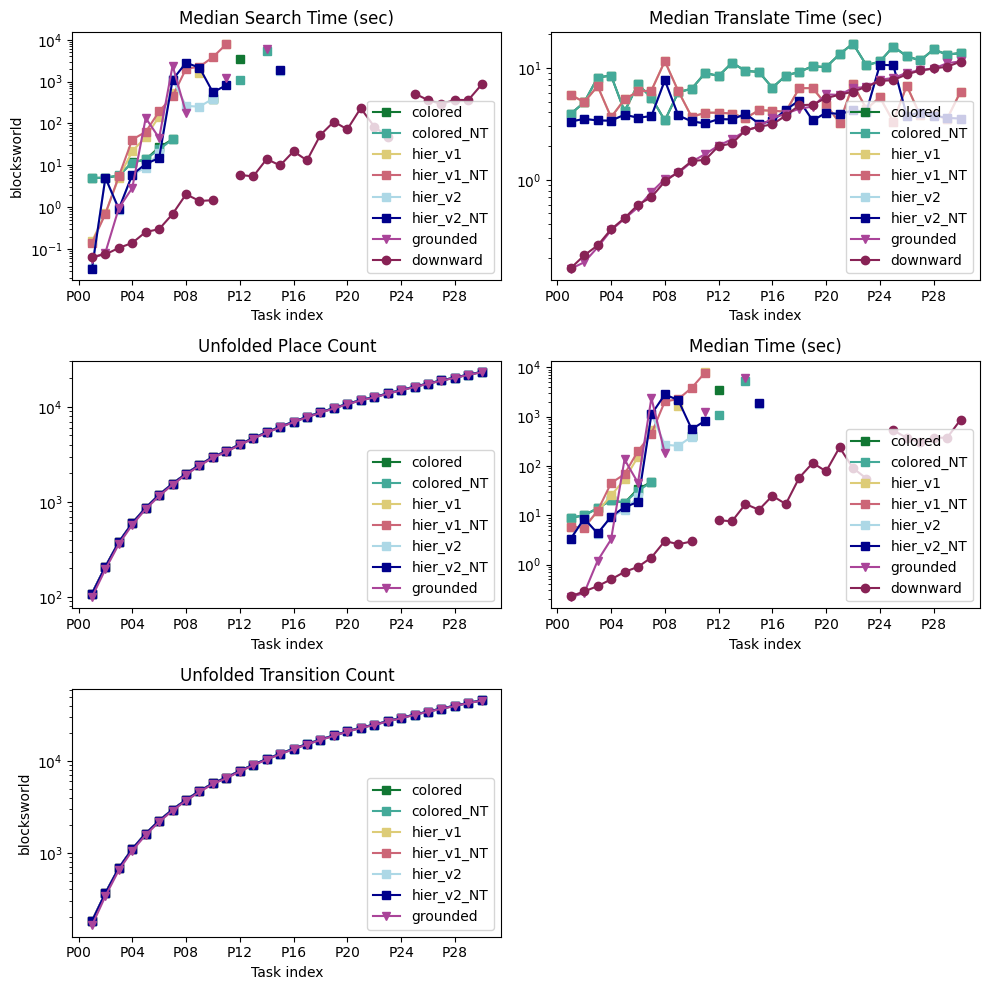

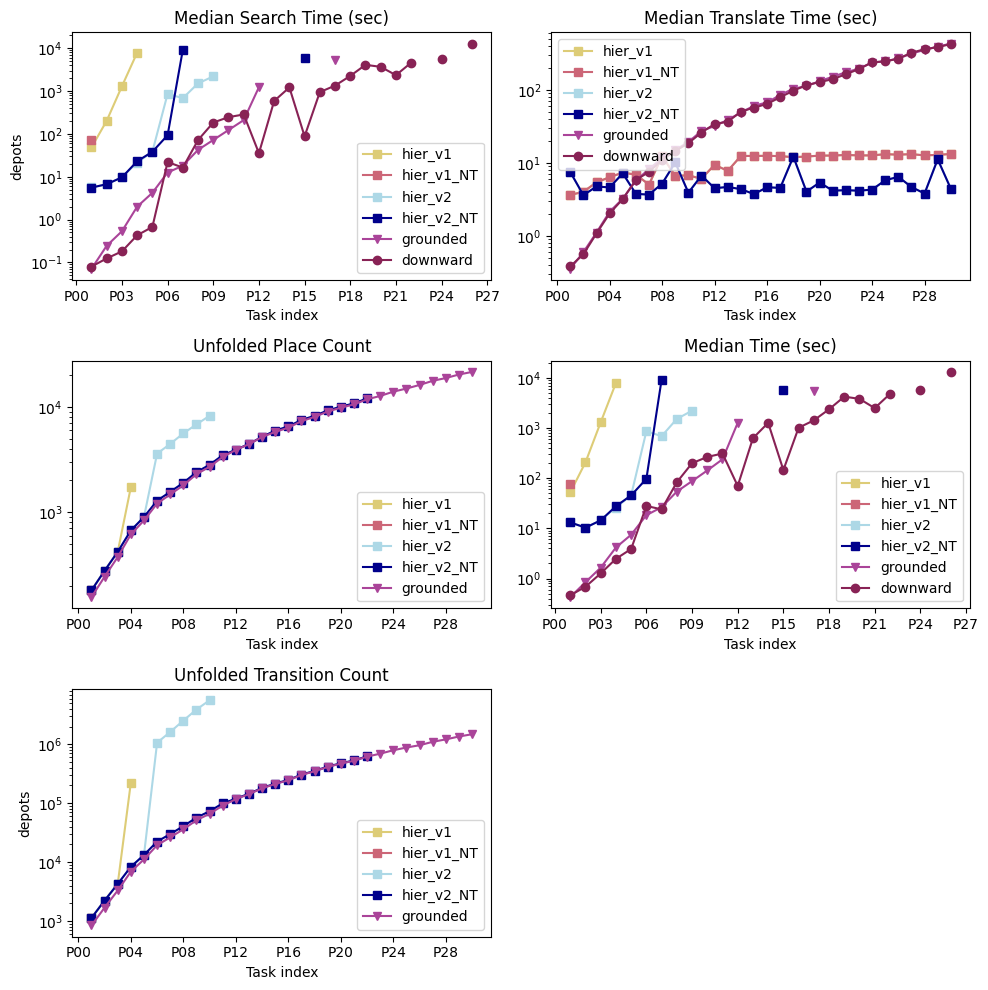

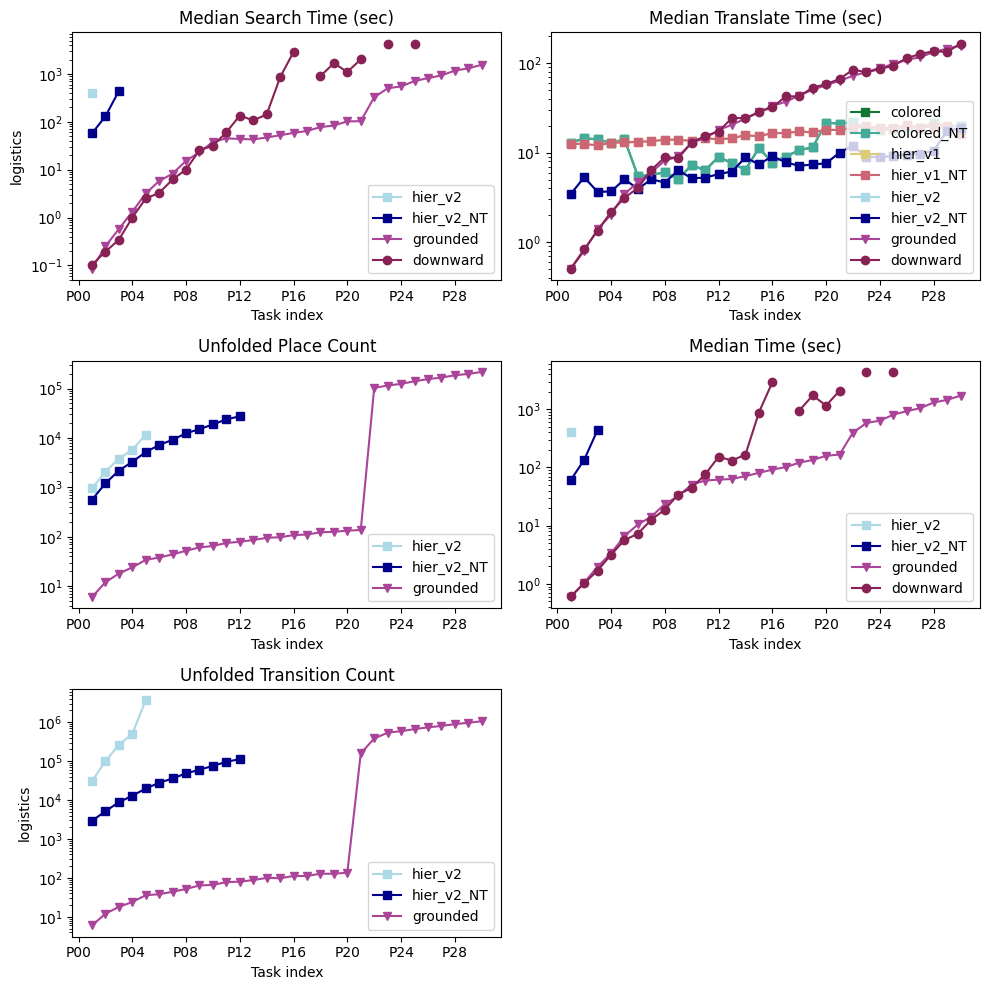

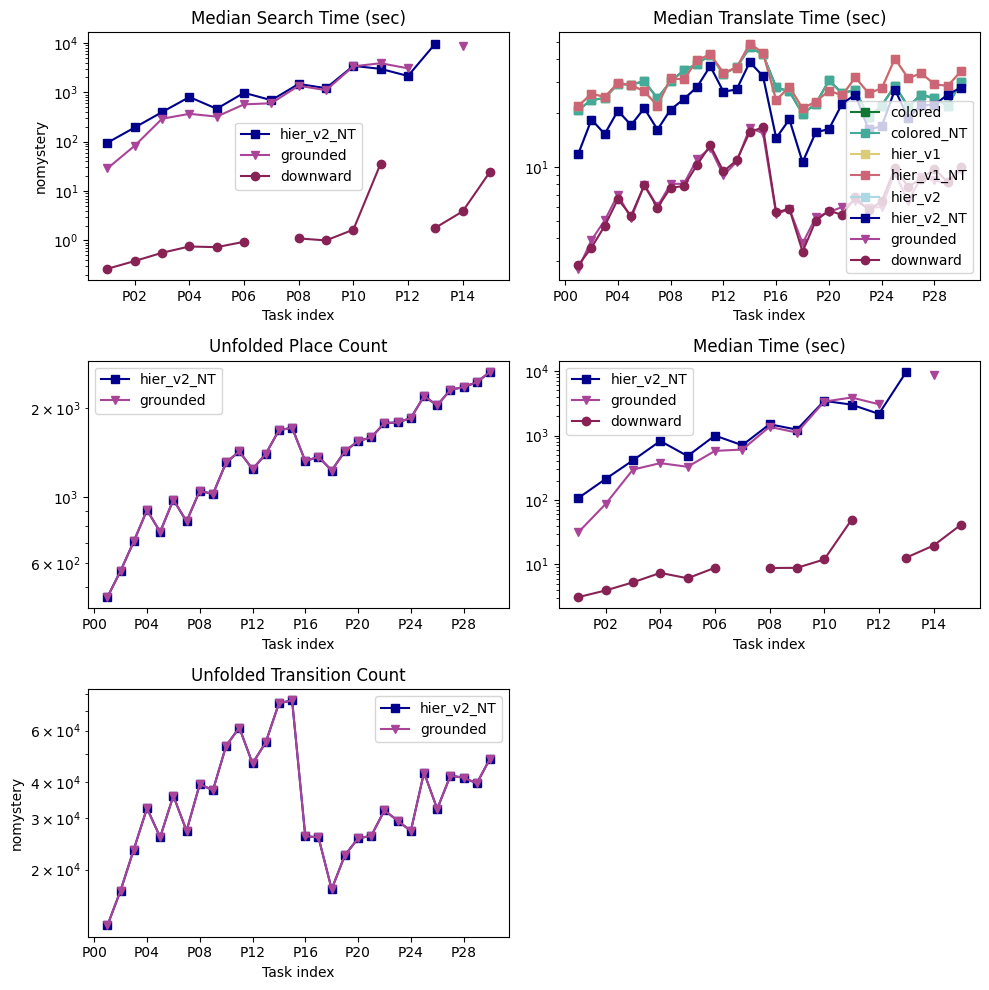

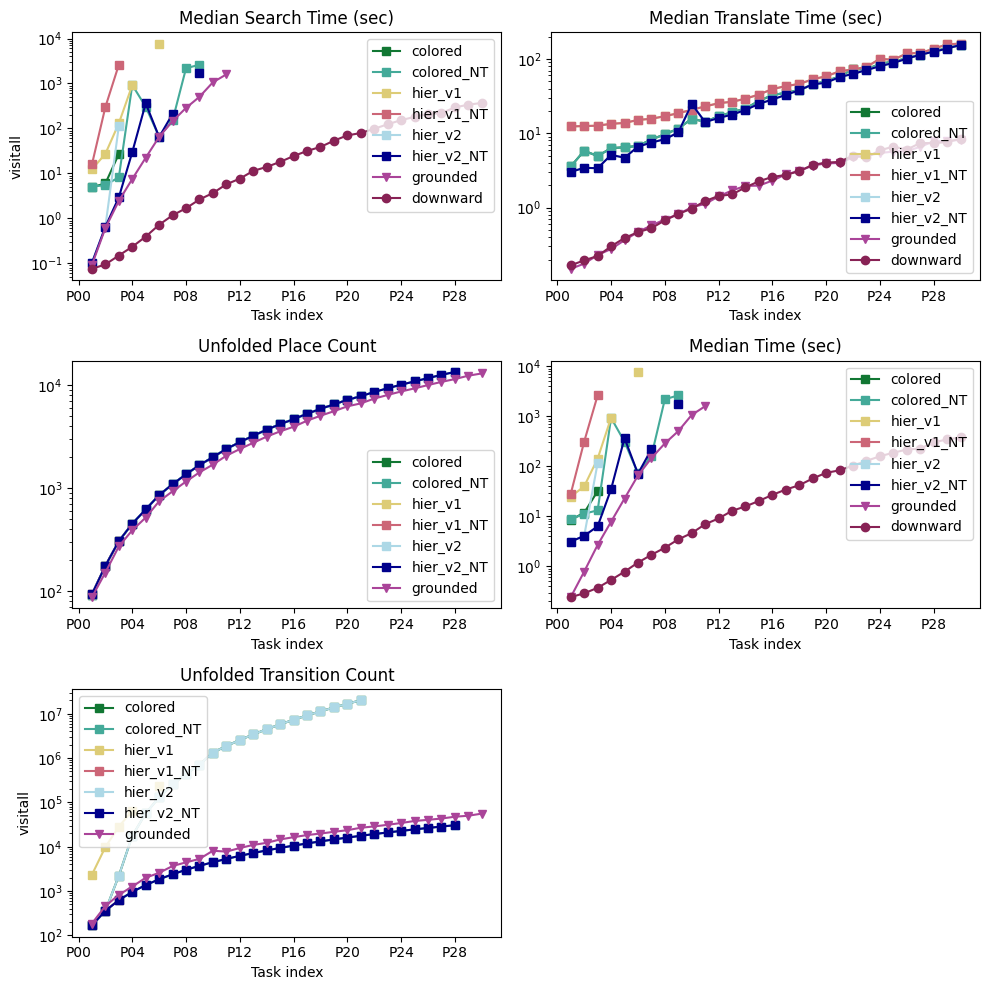

In [28]:
# System + User Time

import matplotlib

xtickFormatter = matplotlib.ticker.FuncFormatter(lambda x, pos: f"P{x:02.0f}")
xtickLocator = matplotlib.ticker.MaxNLocator(integer=True)


def make_domain_cactus_plot(name: str, description: str, rows, cols, reductions: list[tuple[str, Callable[["result_collection"], list[float]]]]):
    fig_rows = rows #1
    fig_cols = cols #len(reductions)

    scale = 10

#    ax = fig.gca()
    # plt.title(description)
    for (domain_name, domain_results) in results.domains.items():
        fig = plt.figure(figsize=(scale, scale))
        i=1
        for (reduction_name, reduction) in reductions:
            subplt = plt.subplot(fig_rows, fig_cols, i)
            max_y = 0
            axis = plt.gca()
            for (translator, translator_results) in domain_results.translators.items():
                for (searcher, resultCollections) in translator_results.searchers.items():
                    reduced_data = reduction(resultCollections)
                    if resultCollections.style != None and len([x for x in reduced_data if x != infinite]) > 0:

                        # if searcher.display_name != "color_rpfs_safe_no_timeout" and searcher.display_name != "hier_rpfs_safe_no_timeout" and searcher.display_name != "grounded":
                        #     continue
                        
                        plt.plot(reduced_data, resultCollections.style, color=resultCollections.color, label=resultCollections.display_name)

                        max_y = max(max_y, max([x for x in reduced_data if x != infinite]))


                        subplt.xaxis.set_major_formatter(xtickFormatter)
                        subplt.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))


            plt.title(reduction_name)
            #plt.title(f'{description} - {test_case.name}')
            plt.gca().legend(loc='best')
            plt.xlabel('Task index')
            if (i-1)%4 == 0:
                plt.ylabel(domain_name)
            subplt.set_yscale("log")
            i += 1


        plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
        plt.tight_layout()
        plt.savefig(os.path.join(plot_save_dir, f"{name}_{domain_name}.png"))

#make_overview_cactus_plot("overview_min_time", "Min Total Time", lambda res: res.min_time)
#make_overview_cactus_plot("overview_min_verificaiton_time", 'Min verification time', lambda resultCollection: min([res.get("time_verification", infinite) for res in resultCollection.raw])) 

#make_overview_cactus_plot("overview_time", 'Median Time (sec)', lambda res: res.median_time)
#make_overview_cactus_plot("overview_time_minus_unfolding", 'Median Time (sec) - minus unfolding', lambda res: res.median_time_minus_unfolding)
#make_overview_cactus_plot("overview_time_minus_unfolding", 'Median unfolding Time (sec)', lambda res: res.median_unfolding_time)

reductions:list[tuple[str, Callable[["result_collection"], float]]] = {
    ('Median Time (sec)', median_time_total),
    ("Median Search Time (sec)", median_time_search),
    ("Median Translate Time (sec)", median_time_translate),
    # ("Median Verification Time",  median_search_property("time_verification")),
    ("Unfolded Place Count", median_search_property("place_count_after_reduction")),
    ("Unfolded Transition Count", median_search_property("transition_count_after_reduction"))
}

make_domain_cactus_plot("name", "description", 3, 2, reductions)
# make_domain_cactus_plot("name", "description", 2, 2, reductions)

## Reductions

In [29]:
# min_time              ", "Min Total Time                     ", lambda res: res.min_time)




# min_verificaiton_time ", 'Min verification time              ', lambda resultCollection: min([res.get("time_verification", infinite) for res in resultCollection.raw])) 




# time                  ", 'Median Time (sec)                  ', lambda res: res.median_time)



# time_minus_unfolding  ", 'Median Time (sec) - minus unfolding', lambda res: res.median_time_minus_unfolding)

# make_overview_cactus_plot("overview_time_minus_unfolding", 'Median Time (sec) - minus unfolding', lambda res: res.median_time_minus_unfolding)

def get_median_time_minus_unfolding(res: ResultCollection):
                
                
                if translator.name=="colored":
                
                plan_lengths = [len(result.plan.actions) if result.get("has_plan", False) else float("inf") for result in results ]
                resultCollection.median_trace_length = statistics.median(plan_lengths)

                time_unfolding = [result["time_unfolding"] if result.get("has_plan", False) else float("inf") for result in results ]
                resultCollection.median_unfolding_time = statistics.median(time_unfolding)

                resultCollection.median_time_minus_unfolding = statistics.median([(result.time.seconds_system + result.time.seconds_user - result["time_unfolding"]) if result.get("has_plan", False) else float("inf") for result in results ])



# time_minus_unfolding  ", 'Median unfolding Time (sec)        ', lambda res: res.median_unfolding_time)


# verification_time     ", "Median Verification Time           ", lambda res: res.median_verification_time)


# unfolded_places       ", "Unfolded Place Count               ", lambda resultCollection: resultCollection.raw[0].get("place_count_after_reduction", infinite))


# unfolded_transitions  ", "Unfolded Transition Count          ", lambda resultCollection: resultCollection.raw[0].get("transition_count_after_reduction", infinite))


IndentationError: expected an indented block after 'if' statement on line 22 (2066450011.py, line 24)